In [ ]:
# Installing the necessary libraries and unzipping the dataset

# Link to the dataset original page: https://snap.stanford.edu/data/reddit_threads.html
!unzip reddit_threads.zip
!pip install spektral
!pip install POT

import scipy as sp
import numpy as np
import matplotlib.pylab as pl
import ot
import pandas as pd
import json

#general libraries
import tensorflow as tf
import numpy as np
import os 
import glob 
import networkx as nx
import pdb
import networkx.algorithms.isomorphism as iso
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

#spektral
from spektral.data import Graph
from spektral.data import Dataset
from spektral.data import DisjointLoader
from spektral.datasets import TUDataset
from spektral.models import GeneralGNN
from spektral.data import DisjointLoader
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool, GeneralConv, GatedGraphConv

#tensorflow imports 
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import DisjointLoader
from spektral.datasets import OGB
from spektral.layers import ECCConv, GlobalSumPool

In [17]:
'''
Graphon functions.
'''

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy as sp
from scipy import io
from scipy import linalg
from scipy import stats
import scipy.interpolate as interpolate

import networkx as nx


from copy import copy
import math

#---------------------------------------------------------------
'''
Reference:
https://github.com/BenjaminSischka/GraphonPy
Sischka, Benjamin and Kauermann, Goran.
"EM-based smooth graphon estimation using MCMC and spline-based approaches."
Social Networks 68. (2022): 279-295.
'''

# Step function approximation from function
def sbm_from_func(func,size):
    if np.isscalar(size):
        Ui = Uj = np.linspace(0,1,size)
        size0 = size1 = size
    else:
        Ui = np.linspace(0,1,size[0])
        Uj = np.linspace(0,1,size[1])
        (size0,size1) = size
    try:
        if func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
            if len(Ui)<len(Uj):
                sbm = np.array([func(Ui[i],Uj) for i in range(size0)])
            else:
                sbm = np.array([func(Ui,Uj[j]) for j in range(size1)])
        else:
            sbm = func(Ui,Uj)
    except ValueError:
        print('Not appropriate graphon definition, slow from function to matrix derivation.')
        sbm = np.zeros((size0,size1))
        for i in range(size0):
            for j in range(size1):
                sbm[i,j] = func(Ui[i],Uj[j])
    return sbm

# Function approximation from B-Spline coefficients
def func_from_theta(theta,tau,order=1,nKnots=None):
    if nKnots is None:
        nKnots = int(np.sqrt(len(theta)))

    if order==0:
        prob_mat = theta.reshape((nKnots,nKnots))
        def _grad_func(x_eval,y_eval):
            vec_x = np.maximum(np.searchsorted(tau, np.array(x_eval, ndmin=1, copy=False)) -1, 0).astype(int)
            vec_y = np.maximum(np.searchsorted(tau, np.array(y_eval, ndmin=1, copy=False)) -1, 0).astype(int)
            return prob_mat[vec_x][:,vec_y]
    else:
        def _grad_func(x_eval,y_eval):
            x_eval_order = np.argsort(x_eval)
            y_eval_order = np.argsort(y_eval)
            func_eval_order=interpolate.bisplev(x= np.array(x_eval, ndmin=1, copy=False)[x_eval_order], y=np.array(y_eval, ndmin=1, copy=False)[y_eval_order], tck=(tau, tau, theta, order, order), dx=0, dy=0)
            return eval('func_eval_order' + (('[np.argsort(x_eval_order)]' + ('[:,' if len(y_eval_order) > 1 else '')) if len(x_eval_order) > 1 else ('[' if len(y_eval_order) > 1 else '')) + ('np.argsort(y_eval_order)]' if len(y_eval_order) > 1 else ''))
    return _grad_func

# Function approximation from step function
def func_from_sbm(sbm):
    def _step_func_aux(u,v):
        if np.isscalar(u):
            return(sbm[np.minimum(np.floor(u*sbm.shape[0]).astype(int), sbm.shape[0]-1)][np.minimum(np.floor(v*sbm.shape[1]).astype(int), sbm.shape[1]-1)])
        else:
            return(sbm[np.minimum(np.floor(u*sbm.shape[0]).astype(int), sbm.shape[0]-1)][:, np.minimum(np.floor(v*sbm.shape[1]).astype(int), sbm.shape[1]-1)])
    return _step_func_aux

# B-Spline coefficients approximation from function
# More accurate: if you create system of equations and solve for theta given nKnots**2 equations
def theta_from_func(func,nKnots=10):
    U = np.linspace(0,1,nKnots)
    try:
        if func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
            prob_mat = np.array([func(U,U[j]) for j in range(nKnots)])
        else:
            prob_mat = func(U,U)
    except ValueError:
        print('Not appropriate graphon definition, slow from function to matrix derivation.')
        prob_mat = np.zeros((nKnots,nKnots))
        for i in range(nKnots):
            for j in range(nKnots):
                prob_mat[i,j] = func(U[i],U[j])
    theta = prob_mat.reshape(nKnots**2)
    return theta

# Ways to represent graphon: b-spline theta, function, or matrix (needs size)
class Graphon:
    def __init__(self, func=None, sbm=None, theta=None, nKnots=10, order=1, size=501):
        if func is None and sbm is None and theta is None:
            print('Error. No information about graphon.')

        if theta is not None:
            nKnots = int(np.sqrt(len(theta)))
        self.nKnots = nKnots
        self.tau = np.concatenate(([0],np.linspace(0,1,self.nKnots),[1]))
        self.order = order

        if func is not None:
            self.func = func
            self.sbm = sbm_from_func(func,size=size)
            self.theta = theta_from_func(func,nKnots=nKnots)
        elif sbm is not None:
            self.sbm = sbm
            self.func = func_from_sbm(sbm)
            self.theta = theta_from_func(self.func,nKnots=nKnots)
        else:
            self.theta = theta
            self.func = func_from_theta(theta,tau=self.tau,order=order,nKnots=nKnots)
            self.sbm = sbm_from_func(self.func,size)
    def sample_graph(self,N,z=None,sorted=False):
        if z is None:
            z = np.random.random(N)
        elif len(z)!=N:
            N = len(z)
        if sorted:
            z = np.sort(z)
        try:
            if self.func(np.array([0.3,0.7]),np.array([0.3,0.7])).ndim == 1:
                A = np.array([np.random.binomial(1,self.func(z,z[i])) for i in range(N)])
            else:
                A = np.random.binomial(1,self.func(z,z))
        except ValueError:
            A = np.zeros((N,N),dtype=int)
            for i in range(N):
                for j in range(N):
                    A[i,j] = np.random.binomial(1,self.func(z[i],z[j]))
        A[np.tril_indices(N)] = A.T[np.tril_indices(N)]
        A[np.eye(N)==1] = 0
        return A,z

def graphon_from_example(idx, size=101,nKnots=10):
    examples = {
                0: lambda u,v: 1/2*(u**2+v**2),
                1: lambda u,v: 1/2*(u+v),
                2: lambda u,v: ((1-u)*(1-v))**(1/1) * 0.8 + (u*v)**(1/1) * 0.85,
                3: lambda u,v: np.exp(-5*np.abs(u-v))
                }
    return Graphon(func=examples[idx],size=size,nKnots=nKnots)

#---------------------------------------------------------------
'''
Reference:
Chan, Stanley and Airoldi, Edoardo.
"A Consistent Histogram Estimator for Exchangeable Graph Models."
ICML, PMLR 32(1) (2014): 208-216.
'''
def graphon_from_sas(A,z=None,num_bins=5,nKnots=10):
    (N,N) = A.shape
    if z is None:
        deg = np.sum(A,axis=0)
        ord_deg = np.argsort(deg)
        A = A[ord_deg,:][:,ord_deg]
        z = (deg[ord_deg]/max(deg+1))

    num_bins = int(np.minimum(N,num_bins))
    F = np.kron(np.eye(num_bins),np.ones((int(np.ceil(N/num_bins)),int(np.ceil(N/num_bins))))-np.eye(int(np.ceil(N/num_bins))))[:N,:N]
    F[np.sum(F,axis=0)>0,:]/=(np.sum(F,axis=0)[np.sum(F,axis=0)>0]).reshape(-1,1)

    sbm = F@A@F.T
    W_est = Graphon(sbm=sbm,nKnots=nKnots)
    return W_est


def GWDistance(A1, A2):
  C1 = sp.spatial.distance.cdist(A1, A1)
  C2 = sp.spatial.distance.cdist(A2, A2)

  C1 /= C1.max()
  C2 /= C2.max()
  p = ot.unif(len(A1))
  q = ot.unif(len(A2))

  gw0, log0 = ot.gromov.gromov_wasserstein(
      C1, C2, p, q, 'square_loss', verbose=True, log=True)


  return log0['gw_dist']

In [6]:
def convert_graph(lst):
  """
  Currently data is represented as dictionary, where
  string with graph ID is mapped to list of all edges.
  This function takes list of edges for the given graphs
  and outputs adjacency matrix 
  """
  lst = np.array(lst)
  size = np.max(np.reshape(np.array(lst), 2*len(lst)))+1

  # Initialize adjacency matrix
  A = np.zeros((size, size))
  for elem in lst:
    a, b = elem[0], elem[1]
    A[a][b] = 1
    A[b][a] = 1
  return A

In [7]:
# Reading the dataset from .csv file

rt = pd.read_csv('reddit_threads/reddit_target.csv') 
with open('/content/reddit_threads/reddit_edges.json') as f:
  data = json.load(f)
f.close()

In [8]:
from spektral.data import Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from numpy import linalg as LA


class MyDataset(Dataset):
    """
    A dataset for training GNN for binary classification, 
    before augmentation
    """

    def __init__(self, data, id, target,indices, **kwargs):
        """
          Inputs:
            - data, the graphs themselves
            - id, the ID number assigned to the graph to keep track of it 
            - target, true labels of the graph
            - indices, which graphs from the entire dataset use for the model
          Outputs:
            - 
            -
            - 
        """
        self.data = data
        self.id = id
        self.target = target
        # Number of graphs in the dataset
        self.number = indices[1]-indices[0]
        self.indices = indices
        super().__init__(**kwargs)

    def read(self):
        # Create one graph, which is i-th in the dataset
        def make_graph(i):
            # Convert to string to access in the original dataset format 
            i = str(i)

            # Get its adjacency matrix 
            A = convert_graph(self.data[i])

            # Return graphs with features, its adjacency matrix, and target label
            return Graph(x=features(A).astype(float), a=csr_matrix(A), y=[target[int(i)]])

        # We must return a list of Graph objects

        return [make_graph(_) for _ in range(self.indices[0], self.indices[1])]

def features(A):
  """
  Extracting features for the graph, 
  given adjacency matrix A.

  Features are:

  In and out degree. Classification
  is entirely topology-based. 

  """
  degreesIn = np.sum(A,axis=1)
  degreesOut = np.sum(A,axis=0)
  return np.column_stack((degreesIn, degreesOut))


In [9]:
id = rt['id']
target = rt['target']

# Create datasets for training, validation, and testing
data_train = MyDataset(data = data, id = id, target = target, indices = [0,500], transforms=NormalizeAdj())

data_val = MyDataset(data = data, id = id, target = target, indices = [10000,10200],transforms=NormalizeAdj())

data_test = MyDataset(data = data, id = id, target = target, indices = [10200,11900],transforms=NormalizeAdj())

In [10]:
# Neural Networks itself

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.transforms.normalize_adj import NormalizeAdj

val_loss_array = []
training_loss = []

################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 40  # Number of training epochs
batch_size =  8 # Batch size


data_tr = data_train
data_va = data_val
data_te = data_test


# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size,epochs=5)
loader_te = DisjointLoader(data_te, batch_size=batch_size,epochs=15)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(5, activation="relu")
        self.conv2 = GCSConv(7, activation="relu")
        self.conv3 = GCSConv(5, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)

# Loss for training
loss_fn1 = MeanSquaredError()

#Loss for evaluation
loss_fn2 = MeanSquaredError()

################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        print("Target: {}".format(target))
        predictions = model(inputs, training=True)
        print("Predictions: {}".format(predictions))
        loss = loss_fn1(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        training_loss.append(format(loss / loader_tr.steps_per_epoch))
        loss = 0

################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = 0
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn2(target, predictions)
loss /= 15*loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Target: Tensor("target:0", shape=(None, 1), dtype=int64)
Predictions: Tensor("net/dense/Sigmoid:0", shape=(None, 1), dtype=float32)
Target: Tensor("target:0", shape=(None, 1), dtype=int64)
Predictions: Tensor("net/dense/Sigmoid:0", shape=(None, 1), dtype=float32)
Loss: 0.23697522282600403
Loss: 0.22588703036308289
Loss: 0.21799401938915253
Loss: 0.21146881580352783
Loss: 0.20579840242862701
Loss: 0.20222748816013336
Loss: 0.19836167991161346
Loss: 0.19726741313934326
Loss: 0.19421568512916565
Loss: 0.19432583451271057
Loss: 0.19232378900051117
Loss: 0.19312359392642975
Loss: 0.19199298322200775
Loss: 0.19159278273582458
Loss: 0.1922541707754135
Loss: 0.19012519717216492
Loss: 0.18940487504005432
Loss: 0.1908678561449051
Loss: 0.18827761709690094
Loss: 0.18745368719100952
Loss: 0.18786120414733887
Loss: 0.1861790269613266
Loss: 0.1878013163805008
Loss: 0.18506069481372833
Loss: 0.18756449222564697
Loss: 0.18579590320587158
Loss: 0.18639785051345825
Loss: 0.1848546862602234
Loss: 0.18429

Text(0, 0.5, 'Training loss, MSE')

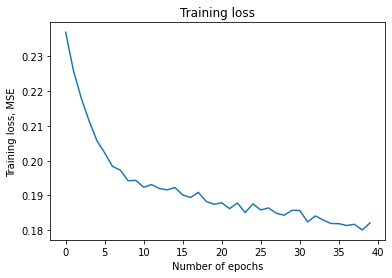

In [11]:
# Plotting the training loss 

tr_ls = []
for elem in training_loss:
  tr_ls.append(float(elem))

plt.plot(tr_ls)

plt.title('Training loss, original dataset')
plt.xlabel('Number of epochs')
plt.ylabel('Training loss, MSE')

In [18]:
def combine_graphons(listA):
  """
  Function to make a linear combination
  of multiple graphons

  Inputs:
    -listA, a list of adjacency matrices for 
    the graphs. For this group
    we want to create one graphon. 
  """

  # Create space to store graphon's SBM
  # represented as matrix
  min_length = np.shape(listA[0])[1]
  graphon = np.zeros((min_length, min_length))
  
  for elem in listA:
    # Graphon inference from individual adjacency
    SWgraphon = graphon_from_sas(elem,num_bins=(int(min_length/2)+1))
    graphon = graphon+SWgraphon.sbm
  
  # Normalize graphon values 
  graphon = graphon / len(listA)

  # Return graphon's SBM as matrix
  return graphon

def augment(dims, target, training_dataset):
  """

  Function that augments the dataset.
  Inputs:
    -dims, list of dimensions for all graphs
    in the dataset we want to augment
    -target, target labels of graphs we want to
    perform augmentation on
    -training_dataset, for which set of graphs augment the data,
    their adjacency matrices
  Outputs:
    - list of lists. Individual element
    is tuple with the new adjacency matrix 
    and its labels 

  """
  dims = np.array(dims)

  all_results={}
  for _ in dims:
    # a = np.where(dims == _)
    for l in [0,1]:
      # Get all graphs that have this dimension _
      all_graphs_one_dim = np.where(dims == _)
      all_graphs_one_dim = list(all_graphs_one_dim[0])

      # Get all graphs with label l
      all_graphs_one_label = np.where(target == l)
      all_graphs_one_label = list(all_graphs_one_label[0])

      # Get graphs same dimension, same label
      one_dim_one_label = np.intersect1d(np.array(all_graphs_one_dim), np.array(all_graphs_one_label))
      results_augmentation_one = np.zeros((len(one_dim_one_label), _,_))
      iter = 0
      for elem in one_dim_one_label:
        results_augmentation_one[iter] = training_dataset[elem]
        iter += 1
      if len(one_dim_one_label) > 0:
        result_of_graphon_comb = combine_graphons(results_augmentation_one)
        all_results[(_,l)] = result_of_graphon_comb
  return all_results 

In [13]:
# For which set of graphs augment the data
training_dataset = []

# Store dimensions of all graphs
dims = []

starting_graph_index = 0
ending_graph_index = 500

for i in range(starting_graph_index, ending_graph_index):
  training_dataset.append(convert_graph(data[str(i)]))
  dims.append(len(convert_graph(data[str(i)])))

dims = np.array(dims)

In [14]:
# Get targets for the dataset
target = rt['target']

# Get graphons and labels for result of augmentation
result_of_augmentation = augment(dims, np.array(target[starting_graph_index:ending_graph_index]), training_dataset)

for elem in result_of_augmentation.keys():
  Adj = result_of_augmentation[elem]

In [15]:
# Augmented Dataset creation(only augmented data) 
class MyDataset(Dataset):
    """
    Dataset with the newly generated graphs
    for augmentation
    """

    def __init__(self, data, **kwargs):
        # Data is list of graphons and labels
        self.data = data
        # to store all Gromow-Wasserstein distances, used for plotting
        self.GWdist = []
        # to store all minimal Gromow-Wasserstein distances for one graphon, used for plotting
        self.minGW = []
        super().__init__(**kwargs)

    def read(self):
        def make_graph(elem):
          
          # Get SBM for graphon, and lavbel 
          _, label = elem[0], elem[1]
          # Adj is actually graphon's SBM
          Adj = self.data[elem]
          # create graphon
          smpl_gr = Graphon(sbm = Adj)

          # size for the new graph
          N = 3*len(Adj)

          # binomial distribution to sample
          zeta = np.sort(np.random.random(N))

          # store all GW distances
          tempGW = []

          # store all minimal GW distances 
          tempM = []

          # among how many sa,pled graphs to choose the best 
          num_graphs_per_graphon = 1

          for i in range(num_graphs_per_graphon):
            # sample graph from graphon
            sample,_ =  smpl_gr.sample_graph(N,z=zeta)
            # create graph from matrix
            G_sample = nx.from_numpy_matrix(sample)

            # get only connected component 
            for component in list(nx.connected_components(G_sample)):
                if len(component)<3:
                    for node in component:
                        G_sample.remove_node(node)
            if G_sample.number_of_edges() > 0:
              new_Adj = nx.to_numpy_array(G_sample)
              tempM.append(new_Adj)
              tempGW.append(float(GWDistance(new_Adj, Adj)))
              self.GWdist.append(float(GWDistance(new_Adj, Adj)))
          # return the closest one
          if len(tempGW)>0:
            self.minGW.append(min(tempGW))
            new_Adj = tempM[0]
            return Graph(x=features(new_Adj).astype(float), a=csr_matrix(new_Adj), y=[label])

        return [make_graph(_) for _ in self.data.keys()]

In [ ]:
data_aug = MyDataset(data=result_of_augmentation, transforms=NormalizeAdj())

In [20]:
# Augmented Dataset and Graph Neural Network

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool
from spektral.transforms.normalize_adj import NormalizeAdj

val_loss_array = []
training_loss = []

################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 8 # Batch size


data_tr = data_train+data_aug
print(data_tr)
data_va = data_val
data_te = data_test


# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size,epochs=5)
loader_te = DisjointLoader(data_te, batch_size=batch_size,epochs=15)


################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GCSConv(5, activation="relu")
        self.conv2 = GCSConv(7, activation="relu")
        self.conv3 = GCSConv(5, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        output = self.global_pool([x, i])
        output = self.dense(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)
loss_fn1 = MeanSquaredError()
loss_fn2 = MeanSquaredError()

################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        print("Target: {}".format(target))
        predictions = model(inputs, training=True)
        print("Predictions: {}".format(predictions))
        loss = loss_fn1(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


step = loss = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        training_loss.append(format(loss / loader_tr.steps_per_epoch))
        loss = 0

################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = 0
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn2(target, predictions)
loss /= 15*loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

Done. Test loss: 0.1875121295452118


Text(0, 0.5, 'Training loss, MSE')

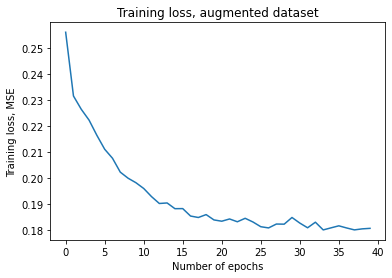

In [21]:
# Plotting the training loss 

tr_ls = []
for elem in training_loss:
  tr_ls.append(float(elem))

plt.plot(tr_ls)

plt.title('Training loss, augmented dataset')
plt.xlabel('Number of epochs')
plt.ylabel('Training loss, MSE')